In [147]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [148]:
fig_dir = '/home/ftp/pub/oriana/qualifying_exam/bart/'
os.makedirs(fig_dir, exist_ok=True)

In [3]:
def read_ascii_vic_forcings(path, index):
    variable_names = ['precipitation', 'tmax', 'tmin', 'wind']
    df = pd.read_csv(path, sep='\t', header=None, names=variable_names)
    df.index=index                                                     
    df = df.drop(['wind'], axis=1)                    
    df.index.rename('date')                                            
    return df

In [4]:
def read_snotel(path):
    df = pd.read_csv(path, skiprows=3, parse_dates=True, index_col='Date')
    
    # Clean up the dataframe and convert to millimeters
    df = df.drop(['Site Id', 'Time', 'Unnamed: 4'], axis=1).rename(columns={'WTEQ.I-1 (in) ': 'SWE (mm)'})*25.4
    # Drop last row because the SNOTEL data has an extra superfluous row at the end
    return df

In [5]:
def calculate_first_snowfree_day(df, wateryear):
    snow_free = df.truncate(before=str(wateryear)+'-04-01')[df.truncate(before=str(wateryear)+'-04-01')['SWE (mm)'] == 0]
    first_snowfree_day = snow_free.index[0]
    return first_snowfree_day

In [6]:
def run_forward_model(met_data_wy, albedo_adjustment=0):
    forward_model = pd.DataFrame(index=met_data_wy.index, columns=['SWE', 'Albedo'])
    bare_soil_albedo = 0
    albedo = bare_soil_albedo
    days_since_last_snowfall = 0
    has_it_snowed = False
    swe = 0
    for index_value in met_data_wy.index:
        # Access the met data for that day
        ta = met_data_wy.get_value(index_value, 'ta')
        precip = met_data_wy.get_value(index_value, 'precipitation')

        # Since we only care about snowfall and we are ignoring rainfall, we only care if temperature is below zero
    #     if ta < 0:
        if precip > 0:
            # If precipitation falls we'll record it in our fallen SWE tracker only if average air temperature is below zero
            if ta < 0:
                has_it_snowed = True
                days_since_last_snowfall = 0
                swe += precip
                albedo = 0.85
            else:
                days_since_last_snowfall += 1
            # Key shortcoming: we don't adjust albedo if it rains
            # If there is no precipitation we allow the albedo to decay with time until 20 days have passed after which
            # we keep it fixed at 0.45
            # Key shortcoming: we use the melt season albedo approximation year-round, even when it is
            # the accumulation season
        if has_it_snowed:
            days_since_last_snowfall += 1
            if days_since_last_snowfall == 0:
                albedo = 0.85+albedo_adjustment
            elif days_since_last_snowfall < 21:
                albedo = 0.75-0.1*np.log(days_since_last_snowfall)+albedo_adjustment
            else:
                albedo = 0.45+albedo_adjustment
        forward_model.set_value(index_value, 'Albedo', albedo)
        forward_model.set_value(index_value, 'SWE', swe)
    return forward_model

In [7]:
# Calculate total potential snow melt to get peak SWE
def calculate_potential_snow_melt(met_data_wy, forward_model, first_snowfree_day):
    potential_snow_melt_df = pd.DataFrame(index=met_data_wy.truncate(after=first_snowfree_day).index, 
                                       columns=['Potential snowmelt'])
    snowmelt_days_backwards = met_data_wy.truncate(after=first_snowfree_day).index[::-1]
    potential_snow_melt = 0
    for day_index in snowmelt_days_backwards:
        melt_factor = 4.0 * ( 1 - forward_model.get_value(day_index, 'Albedo')) * np.exp( -4*locations[site]['cover'])
        air_temp = met_data.get_value(day_index, 'ta')
        if air_temp >= 0:
            potential_snow_melt += melt_factor * air_temp
        potential_snow_melt_df.set_value(day_index, 'Potential snowmelt', potential_snow_melt)
    return potential_snow_melt_df

In [8]:
def calculate_peak_swe_and_date(met_data_wy, potential_snow_melt_df):
    snowmelt_days_backwards = met_data_wy.truncate(after=first_snowfree_day).index[::-1]
    for day_index in snowmelt_days_backwards:
        today_potential_snowmelt = potential_snow_melt_df.get_value(day_index, 'Potential snowmelt')
        thirty_days_before_potential_snowmelt = potential_snow_melt_df.iloc[potential_snow_melt_df.index.get_loc(day_index) - 30].values
    # Assume that if the day's snowmelt has remained about the same (within 5%) of the potential snowmelt
    # from 30 days before then the peak SWE has been reached
        if today_potential_snowmelt/thirty_days_before_potential_snowmelt > 0.95:
            peak_swe_day_of_year = np.where(met_data_wy.index==day_index)[0][0]
            peak_swe_value = today_potential_snowmelt
            break
    return peak_swe_day_of_year, peak_swe_value

In [9]:
locations = {'Wells Creek, WA': {'site_number': '909',
                            'latitude': '48.84375',
                            'longitude': '-121.78125',
                                'cover': 0.0,
                                'color': 'b'},
            'Truckee #2, CA' : {'site_number': '834',
                          'latitude': '39.28125',
                          'longitude': '-120.15625',
                               'cover': 0.0,
                               'color': 'g'},
            'Beaver Dams, UT': {'site_number': '329',
                           'latitude': '39.15625',
                           'longitude': '-111.53125',
                               'cover': 0.0,
                               'color': 'orange'}}

In [167]:
results_dict = {'Peak SWE Date': {},
               'Peak SWE Values': {}}
years = range(2006,2011)
for site in locations.keys():
    print(site)
    results_dict['Peak SWE Date'][site] = pd.DataFrame(index=years, columns=['SNOTEL', 'Modeled'])
    results_dict['Peak SWE Values'][site] = pd.DataFrame(index=years, columns=['SNOTEL', 'Modeled'])
    for wy in years:

        site_number = locations[site]['site_number']
        latitude, longitude = locations[site]['latitude'], locations[site]['longitude']

        # Read in SNOTEL SWE data
        snotel = read_snotel('snotel/'+site_number+'_26_WATERYEAR='+str(wy)+'.csv')

        # Calculate peak SWE from SNOTEL
        peak_snotel_swe = snotel.max().values[0]
        peak_snotel_swe_day_of_water_year = np.where(snotel['SWE (mm)'].index==snotel['SWE (mm)'].argmax())[0][0]


        results_dict['Peak SWE Date'][site].set_value(wy, 'SNOTEL', peak_snotel_swe_day_of_water_year)
        results_dict['Peak SWE Values'][site].set_value(wy, 'SNOTEL', peak_snotel_swe)
        # Calculate first snow free day
        # Assumptions: First snow-free day after April 1
        first_snowfree_day = calculate_first_snowfree_day(snotel, wy)

        # Read in ascii met file
        met_data = read_ascii_vic_forcings('livneh/data_'+latitude+'_'+longitude, index=pd.date_range('1915-01-01', '2011-12-31'))
        # Average temp to get average daily temp
        met_data['ta'] = (met_data['tmax']+met_data['tmin'])/2
        met_data_wy = met_data.truncate(before=str(wy-1)+'-10-01', after=str(wy)+'-09-30')
#         snotel.plot()
# Run model
        forward_model = run_forward_model(met_data_wy)
# potential_snowmelt
        potential_snow_melt_df = calculate_potential_snow_melt(met_data_wy, forward_model, first_snowfree_day)
#         potential_snow_melt_df.plot()
        peak_swe_date, peak_swe = calculate_peak_swe_and_date(met_data_wy, potential_snow_melt_df)
        results_dict['Peak SWE Date'][site].set_value(wy, 'Modeled', peak_swe_date)
        results_dict['Peak SWE Values'][site].set_value(wy, 'Modeled', peak_swe)

# Plot scatter plot of day of year
# Plot scatter plot of max SWE

Beaver Dams, UT
Wells Creek, WA
Truckee #2, CA


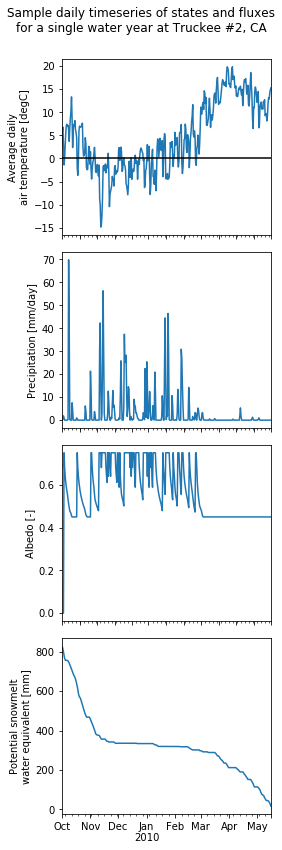

In [168]:
figure, axarr = plt.subplots(4,1, figsize=(4,12))
plt.suptitle('Sample daily timeseries of states and\nfluxes for a single water year at '+site)#, y=0.92)

# plot temperature
met_data_wy['zeros'] = 0
ax = met_data_wy['ta'].plot(ax=axarr[0], sharex=True)
met_data_wy['zeros'].plot(ax=axarr[0], color='k')
axarr[0].set_ylabel('Average daily\nair temperature [degC]')

# plot precipitation
met_data_wy['precipitation'].plot(ax=axarr[1])
axarr[1].set_ylabel('Precipitation [mm/day]')

forward_model['Albedo'].plot(ax=axarr[2])
axarr[2].set_ylabel('Albedo [-]')

potential_snow_melt_df.plot(ax=axarr[3],legend=False)
axarr[3].set_ylabel('Potential snowmelt\nwater equivalent [mm]')
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.suptitle('Sample daily timeseries of states and fluxes\nfor a single water year at '+site)#, y=0.92)

plt.savefig(fig_dir+'met_data_ts.png')

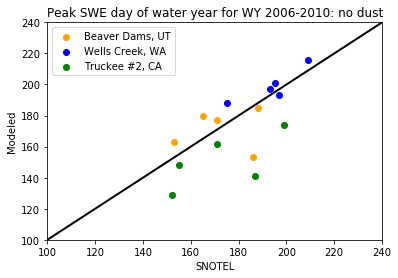

In [169]:
lower_limit, upper_limit = 100, 240
figure, axarr = plt.subplots()
scatters,labels = [], []
for location in locations.keys():
    scatters.append(axarr.scatter(results_dict['Peak SWE Date'][location]['SNOTEL'].values, 
            results_dict['Peak SWE Date'][location]['Modeled'].values,color=locations[location]['color']))
    labels.append(location)
plt.xlim(lower_limit,upper_limit)
plt.ylim(lower_limit,upper_limit)
plt.plot([lower_limit, upper_limit], [lower_limit, upper_limit], color='k', linestyle='-', linewidth=2)
plt.xlabel('SNOTEL')
plt.ylabel('Modeled')
plt.legend(scatters,labels)
plt.title('Peak SWE day of water year for WY 2006-2010: no dust')
plt.savefig(fig_dir+'day_of_wy_nodust.png')

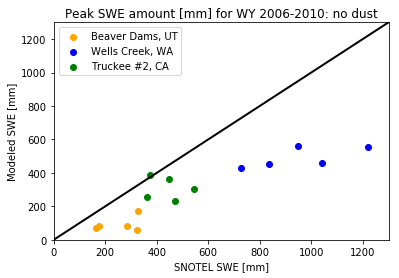

In [170]:
lower_limit, upper_limit = 0, 1300
figure, axarr = plt.subplots()
scatters,labels = [], []

for location in locations.keys():
    scatters.append(axarr.scatter(results_dict['Peak SWE Values'][location]['SNOTEL'].values, 
            results_dict['Peak SWE Values'][location]['Modeled'].values,color=locations[location]['color']))
    labels.append(location)

plt.xlim(lower_limit,upper_limit)
plt.ylim(lower_limit,upper_limit)
plt.plot([lower_limit, upper_limit], [lower_limit, upper_limit], color='k', linestyle='-', linewidth=2)
plt.xlabel('SNOTEL SWE [mm]')
plt.ylabel('Modeled SWE [mm]')
plt.legend(scatters,labels)

plt.title('Peak SWE amount [mm] for WY 2006-2010: no dust')
plt.savefig(fig_dir+'peak_swe_amount_nodust.png')

In [171]:
results_dict = {'Peak SWE Date': {},
               'Peak SWE Values': {}}
years = range(2006,2011)
for site in locations.keys():
    results_dict['Peak SWE Date'][site] = pd.DataFrame(index=years, columns=['SNOTEL', 'Modeled'])
    results_dict['Peak SWE Values'][site] = pd.DataFrame(index=years, columns=['SNOTEL', 'Modeled'])
    for wy in years:

        site_number = locations[site]['site_number']
        latitude, longitude = locations[site]['latitude'], locations[site]['longitude']

        # Read in SNOTEL SWE data
        snotel = read_snotel('snotel/'+site_number+'_26_WATERYEAR='+str(wy)+'.csv')

        # Calculate peak SWE from SNOTEL
        peak_snotel_swe = snotel.max().values[0]
        peak_snotel_swe_day_of_water_year = np.where(snotel['SWE (mm)'].index==snotel['SWE (mm)'].argmax())[0][0]


        results_dict['Peak SWE Date'][site].set_value(wy, 'SNOTEL', peak_snotel_swe_day_of_water_year)
        results_dict['Peak SWE Values'][site].set_value(wy, 'SNOTEL', peak_snotel_swe)
        # Calculate first snow free day
        # Assumptions: First snow-free day after April 1
        first_snowfree_day = calculate_first_snowfree_day(snotel, wy)

        # Read in ascii met file
        met_data = read_ascii_vic_forcings('livneh/data_'+latitude+'_'+longitude, index=pd.date_range('1915-01-01', '2011-12-31'))
        # Average temp to get average daily temp
        met_data['ta'] = (met_data['tmax']+met_data['tmin'])/2
        met_data_wy = met_data.truncate(before=str(wy-1)+'-10-01', after=str(wy)+'-09-30')
#         snotel.plot()
# Run model
        forward_model = run_forward_model(met_data_wy, albedo_adjustment=-0.3)
# potential_snowmelt
        potential_snow_melt_df = calculate_potential_snow_melt(met_data_wy, forward_model, first_snowfree_day)
#         potential_snow_melt_df.plot()
        peak_swe_date, peak_swe = calculate_peak_swe_and_date(met_data_wy, potential_snow_melt_df)
        results_dict['Peak SWE Date'][site].set_value(wy, 'Modeled', peak_swe_date)
        results_dict['Peak SWE Values'][site].set_value(wy, 'Modeled', peak_swe)

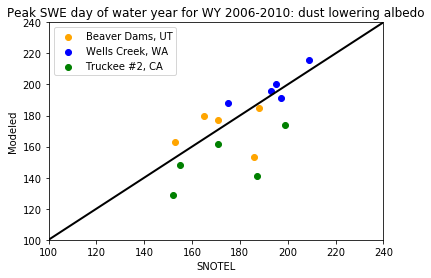

In [172]:
lower_limit, upper_limit = 100, 240
figure, axarr = plt.subplots()
scatters,labels = [], []

for location in locations.keys():
    scatters.append(axarr.scatter(results_dict['Peak SWE Date'][location]['SNOTEL'].values, 
            results_dict['Peak SWE Date'][location]['Modeled'].values,color=locations[location]['color']))
    labels.append(location)
plt.xlim(lower_limit,upper_limit)
plt.ylim(lower_limit,upper_limit)
plt.plot([lower_limit, upper_limit], [lower_limit, upper_limit], color='k', linestyle='-', linewidth=2)
plt.xlabel('SNOTEL')
plt.ylabel('Modeled')
plt.legend(scatters,labels)

plt.title('Peak SWE day of water year for WY 2006-2010: dust lowering albedo')
plt.savefig(fig_dir+'day_of_wy_dust.png')

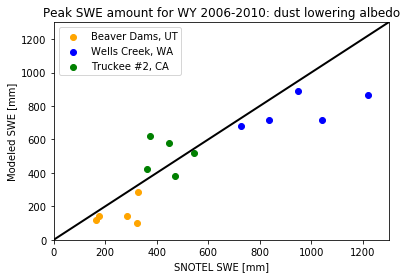

In [173]:
lower_limit, upper_limit = 0, 1300
figure, axarr = plt.subplots()
scatters,labels = [], []

for location in locations.keys():
    scatters.append(axarr.scatter(results_dict['Peak SWE Values'][location]['SNOTEL'].values, 
            results_dict['Peak SWE Values'][location]['Modeled'].values,color=locations[location]['color']))
    labels.append(location)
plt.xlim(lower_limit,upper_limit)
plt.ylim(lower_limit,upper_limit)
plt.plot([lower_limit, upper_limit], [lower_limit, upper_limit], color='k', linestyle='-', linewidth=2)
plt.xlabel('SNOTEL SWE [mm]')
plt.ylabel('Modeled SWE [mm]')
plt.legend(scatters,labels)

plt.title('Peak SWE amount for WY 2006-2010: dust lowering albedo')
plt.savefig(fig_dir+'peak_swe_amount_dust.png')